In [1]:
from __future__ import print_function

from misc.config import Config
from trainer import JoImTeR as trainer
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances,cosine_distances
from matplotlib import pyplot as plt
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
# import os
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
import argparse
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import pickle
import warnings
from tqdm import tqdm
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from matplotlib import pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

from PIL import Image
import datetime
import dateutil.tz
from misc.utils import mkdir_p
# from datasets import prepare_data
from model import ImageEncoder,TextEncoder
import dataset_classification,dataset
from misc.losses import words_loss,words_triplet_loss
from transformers import BertConfig
from misc.config import Config
cfg = Config()

In [2]:
proj_ds=pd.read_csv('../data/indiana_projections.csv')
repo_ds=pd.read_csv('../data/indiana_reports.csv')


In [3]:
torch.cuda.set_device(3)
cudnn.benchmark = True

In [4]:
cfg.CUDA = True
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if cfg.CUDA:
    torch.cuda.manual_seed_all(cfg.seed)


In [128]:
data_set = dataset.build_dataset('test', cfg)
test_loader = torch.utils.data.DataLoader(
                data_set, batch_size=100, drop_last=False,
                shuffle=False, num_workers=1)
data_iter = iter(test_loader)

In [129]:

bert_config = BertConfig(vocab_size=test_loader.dataset.vocab_size, hidden_size=512, num_hidden_layers=3,
                    num_attention_heads=8, intermediate_size=2048, hidden_act='gelu',
                    hidden_dropout_prob=cfg.hidden_dropout_prob, attention_probs_dropout_prob=cfg.attention_probs_dropout_prob,
                    max_position_embeddings=512, layer_norm_eps=1e-12,
                    initializer_range=0.02, type_vocab_size=2, pad_token_id=0)

def build_model(cfg):
    image_encoder = ImageEncoder(output_channels=cfg.hidden_dim)

    if cfg.text_encoder_path != '':

        img_encoder_path = cfg.text_encoder_path.replace('text_encoder', 'image_encoder')
#         print('Load image encoder from:', img_encoder_path)
        state_dict = torch.load(img_encoder_path, map_location='cpu')
        if 'model' in state_dict.keys():
            image_encoder.load_state_dict(state_dict['model'])
        else:
            image_encoder.load_state_dict(state_dict)
    for p in image_encoder.parameters(): # make image encoder grad on
        p.requires_grad = False


    #         image_encoder.eval()
    epoch = 0

    ###################################################################
    text_encoder = TextEncoder(bert_config = bert_config)
    if cfg.text_encoder_path != '':
        text_encoder_path = cfg.text_encoder_path
#         print('Load text encoder from:', text_encoder_path)
        state_dict = torch.load(text_encoder_path, map_location='cpu')
        if 'model' in state_dict.keys():
            text_encoder.load_state_dict(state_dict['model'])
        else:
            text_encoder.load_state_dict(state_dict)
    for p in text_encoder.parameters(): # make text encoder grad on
        p.requires_grad = False

    # ########################################################### #
    if cfg.CUDA:
        text_encoder = text_encoder.cuda()
        image_encoder = image_encoder.cuda()
    return text_encoder.eval(),image_encoder.eval()

In [130]:
model_path = '../output/OpenI_test_combo_t4.0s0.5.w0.5_d2.0-01.01.02_2020_12_09_13_14_01/Model/text_encoder.pth'

In [131]:
cfg.text_encoder_path = model_path
text_encoder, image_encoder = build_model(cfg)


In [132]:
data_iter = iter(test_loader)

In [133]:
imgs, captions, masks, class_ids, cap_lens = data_iter.next()


In [134]:
if cfg.CUDA:
    imgs, captions, masks, cap_lens = imgs.cuda(), captions.cuda(), masks.cuda(), cap_lens.cuda()
     

In [135]:
class_ids = class_ids.numpy()

In [136]:
labels = Variable(torch.LongTensor(range(test_loader.batch_size))) # used for matching loss
        
if cfg.CUDA:
    labels = labels.cuda()

In [137]:
ids = np.array(list(range(test_loader.batch_size)))
neg_ids = Variable(torch.LongTensor([np.random.choice(ids[ids!=x]) for x in ids])) # used for matching loss
                
neg_ids = neg_ids.cuda()
neg_ids

tensor([86, 26, 90,  9, 21, 95, 63,  5, 14, 33, 71, 24, 73, 75, 87, 51,  1, 14,
        35, 36, 92, 39,  3, 64, 74,  5, 57, 30, 99, 74, 96, 67, 90, 14, 16, 91,
        17, 18, 76, 88, 69, 23, 91, 48, 29, 14, 47, 43, 98, 26, 84, 64, 40, 96,
        68,  4, 52,  7, 21,  6, 21, 45, 29, 15, 79,  4, 67, 22, 60, 74,  4, 22,
        79, 82, 24,  7, 95, 20,  1, 21, 71, 87, 96, 71, 67, 63, 94, 18, 86, 81,
        52, 93, 86, 97, 51, 46, 81, 53, 43, 96], device='cuda:3')

In [138]:
r_feats, v_feats = image_encoder(imgs)
w_feats, s_feats = text_encoder(captions,masks)

In [139]:
loss0, loss1, att_maps = words_loss(r_feats,w_feats[:,:,1:],labels, cap_lens-1, class_ids, test_loader.batch_size)

In [140]:
loss0_t, loss1_t, att_maps = words_triplet_loss(r_feats,w_feats[:,:,1:],labels, neg_ids, cap_lens-1, test_loader.batch_size)

In [184]:
idx = 69

In [185]:
pd.options.display.max_colwidth = 0
repo_ds[repo_ds.uid==class_ids[idx]]

,uid,MeSH,Problems,image,indication,comparison,findings,impression
1080,1115,normal,normal,"PA lateral chest x-XXXX XXXX, XXXX XXXX hours",Mass in axilla,None available,Normal heart size and mediastinal contours. No abnormal airspace opacities. No pleural effusion or pneumothorax. Visualized osseous structures are unremarkable appearance.,No acute cardiopulmonary abnormalities.


In [186]:
sent_tokens = np.array([data_set.idx2word[x] for x in captions[idx][:masks[idx].sum()].detach().cpu().numpy()])[1:]

In [187]:
' '.join(sent_tokens)

'normal heart size and mediastinal contours no abnormal airspace opacities no pleural effusion or pneumothorax visualized osseous structures are unremarkable appearance [SEP]'

In [177]:
imgs_selected = imgs.detach().cpu().numpy()

In [178]:
imgs_selected = (imgs_selected[idx][0]+1)/2
imgs_selected.min(),imgs_selected.max()

(0.04705882, 1.0)

In [179]:
# i = 0
# for attn_map in att_maps[idx][0].detach().cpu().numpy():
#     print(sent_tokens[i])
#     plt.imshow(imgs_selected, alpha=0.5, cmap='gray')
#     plt.imshow(cv2.resize(attn_map,(2048,2048),cv2.INTER_CUBIC), cmap='jet', alpha=0.5)
#     plt.show()
#     i+=1

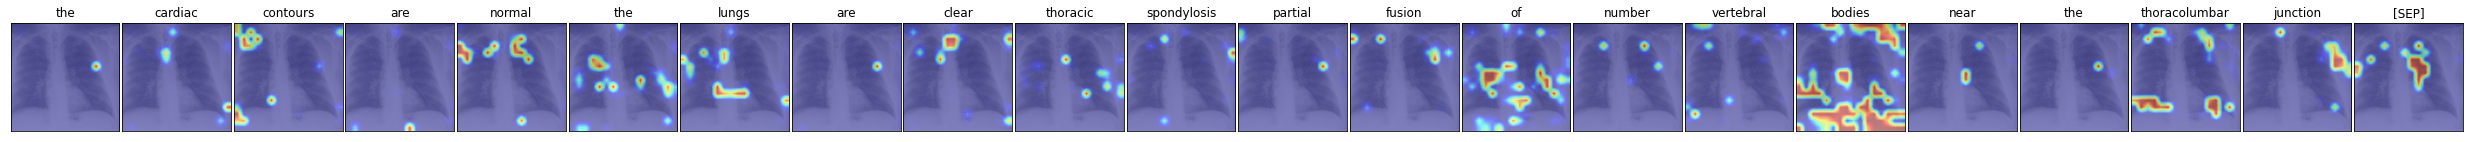

In [166]:
import matplotlib.gridspec as gridspec

maps = att_maps[idx][0].detach().cpu().numpy()


w=10
h=10
fig=plt.figure(figsize=(2*maps.shape[0],2))

columns = maps.shape[0]
rows = 1
ax = []
for i in range(columns*rows):
    img = np.random.randint(10, size=(h,w))
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(sent_tokens[i])  # set title
    plt.imshow(imgs_selected, alpha=0.5, cmap='gray')
    plt.imshow(cv2.resize(maps[i],(2048,2048),cv2.INTER_CUBIC), cmap='jet', alpha=0.5)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
# for i in range(1, columns*rows +1):
# #     print(i)
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(imgs_selected, alpha=0.5, cmap='gray')
#     plt.imshow(cv2.resize(maps[i-1],(2048,2048),cv2.INTER_CUBIC), cmap='jet', alpha=0.5)
#     ax[-1].set_title(sent_tokens[i-1])
# #     plt.show()
plt.show()

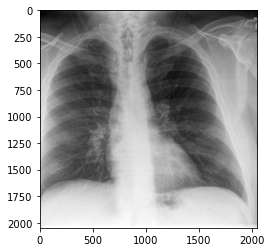

In [167]:
plt.imshow(imgs_selected,cmap='gray')